In [1]:
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path("../..").absolute()))
from IPython.display import display, clear_output, Image
from system import HierarchicalSystemBuilder
from environment import MultiStageEnv
from computation_sim.system import SystemDrawer
from computation_sim.nodes import ConstantNormalizer
from computation_sim.time import GammaDistributionSampler, GaussianTimeSampler, Clock, DurationSampler
from matplotlib import pyplot as plt
from typing import List, Tuple

In [2]:
DELTA_T = 10
# Set-up some default parameters
params = {
    "environment" : {
        "dt": DELTA_T, 
        "cost_input": 0.01, # Regularization cost for input
        "cost_message_loss": 1.0, # Primary goal: Minimize message loss
        "cost_output_time": 0.1 / 100.0, # Secondary goal: Minimize age of oldest information in the output
    }
}

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 1.0},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'a2fc9afb-3f56-4c95-852d-acbfcf929195',
              'x': [-0.4303030303030303, -0.2484848484848485, None, ...,
                    0.4787878787878788, 0.6606060606060606, None],
              'y': [-0.9090909090909092, -0.9090909090909092, None, ...,
                    0.18181818181818182, 0.09090909090909091, None]},
             {'hovertext': [num_messages = 0, num_messages = 0, num_messages = 0,
                            num_messages = 0, num_messages = 0, num_messages = 0, ,
                            is_occupied = 0.0<br>msg.age_oldest =
                            0.0<br>msg.age_youngest = 0.0<br>msg.age_average =
                            0.0<br>, is_busy = True<br>t_start_age = 0.0,
                            is_occupied = 0.0<br>msg.age_oldest =
 

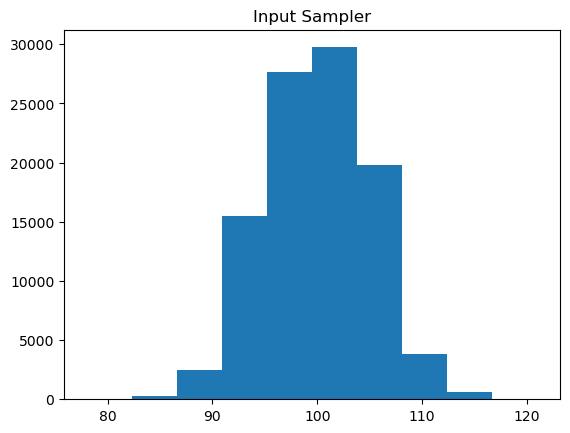

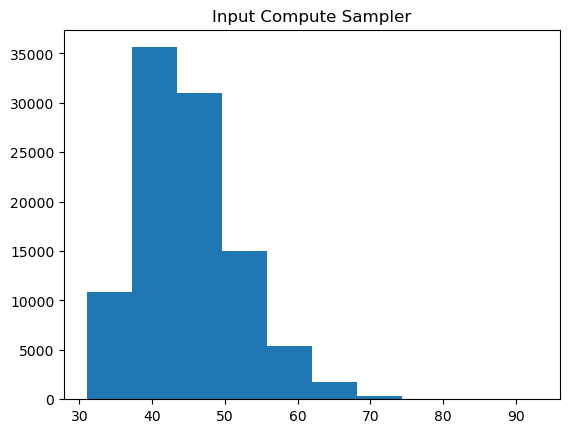

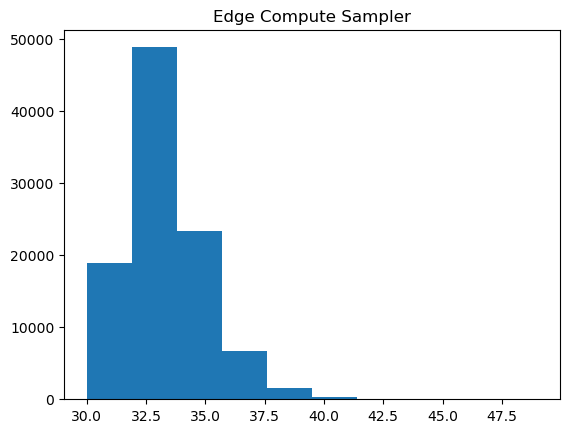

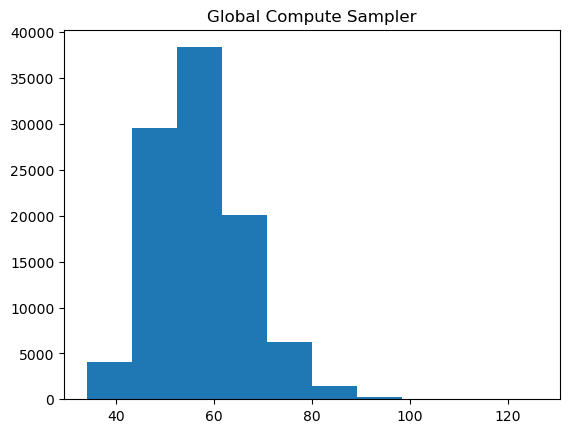

In [3]:
class EnvBuilder:
    def __init__(self, dt = 1, cost_message_loss=1.0, cost_output_time=0.001, cost_input=0.1):
        self.input_sampler = GaussianTimeSampler(0.0, 1.0, 5.0, 100.0)
        self.input_compute_sampler = GammaDistributionSampler(5.0, 1.0, 3.0, 30.0)
        self.edge_compute_sampler = GammaDistributionSampler(3.0, 1.0, 1.0, 30.0)
        self.global_compute_sampler = GammaDistributionSampler(9.0, 1.0, 3.0, 30.0)
        self.age_normalizer = ConstantNormalizer(100.0)
        self.count_normalizer = ConstantNormalizer(1.0)
        self.occupancy_normalizer = ConstantNormalizer(1.0)
        self.dt = dt
        self.cost_message_loss = 1.0
        self.cost_output_time = 0.001
        self.cost_input = 0.1

    def build(self) -> MultiStageEnv:
        clock = Clock(0)
        builder = HierarchicalSystemBuilder(clock, self.age_normalizer, self.count_normalizer, self.occupancy_normalizer)

        # Set-up the sensor chains
        s0 = [
            builder.add_sensor_chain("0", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("1", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("2", 0, 100, self.input_sampler, self.input_compute_sampler)
        ]
        s1 = [
            builder.add_sensor_chain("3", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("4", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("5", 0, 100, self.input_sampler, self.input_compute_sampler)
        ]
        s2 = [
            builder.add_sensor_chain("6", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("7", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("8", 0, 100, self.input_sampler, self.input_compute_sampler),
        ]
        s3 = [
            builder.add_sensor_chain("9", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("10", 0, 100, self.input_sampler, self.input_compute_sampler),
        ]

        # Set-up the edge nodes
        m = [
            builder.add_edge_compute("0", s0, self.edge_compute_sampler, 100.0),
            builder.add_edge_compute("1", s1, self.edge_compute_sampler, 100.0),
            builder.add_edge_compute("2", s2, self.edge_compute_sampler, 100.0),
            builder.add_edge_compute("3", s3, self.edge_compute_sampler, 100.0)
        ]

        # Set-up the output node
        builder.add_output_compute(m, self.global_compute_sampler, 100.0)
        builder.build()

        system = builder.system
        system.update()
        sinks = [
            builder._nodes["SENSOR_BUFFER_LOST"],
            builder._nodes["SENSOR_COMPUTE_LOST"],
            builder._nodes["SENSOR_COMPUTE_BUFFER_LOST"],
            builder._nodes["EDGE_COMPUTE_LOST"],
            builder._nodes["EDGE_COMPUTE_BUFFER_LOST"],
            builder._nodes["OUTPUT_COMPUTE_LOST"],
        ]
        output = builder.nodes["OUTPUT"]
        return MultiStageEnv(clock, system, sinks, output, self.dt, self.cost_message_loss, self.cost_output_time, self.cost_input)

def plot_sampler(sampler: DurationSampler, n: int = 100000) -> Tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(1, 1)
    samples = [sampler.sample() for i in range(n)]
    ax.hist(samples)
    return fig, ax

# Build the environment
builder = EnvBuilder(**params["environment"])
env = builder.build()

# Plott histograms of the execution time distributions
fig, ax = plot_sampler(builder.input_sampler)
ax.set_title('Input Sampler')
fig, ax = plot_sampler(builder.input_compute_sampler)
ax.set_title('Input Compute Sampler')
fig, ax = plot_sampler(builder.edge_compute_sampler)
ax.set_title('Edge Compute Sampler')
fig, ax = plot_sampler(builder.global_compute_sampler)
ax.set_title('Global Compute Sampler')

# Draw the system to visualize the structure
drawer = SystemDrawer()
drawer.build(env.system.node_graph)
drawer.fw.update_layout(height=800)

# Display the environment
clear_output(wait=True)
display(drawer.fw)
